In [38]:
## Load and save datasets

from datasets import load_dataset

dataset = "sarus-tech/phee"


ds = load_dataset(dataset)
ds.save_to_disk('../data/raw/'+dataset)

Saving the dataset (1/1 shards): 100%|██████████| 961/961 [00:00<00:00, 54665.03 examples/s]


In [39]:
## Load dataset from disk

from datasets import load_from_disk

ds = load_from_disk('../data/raw/'+dataset)

In [40]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'context', 'is_mult_event', 'annotations'],
        num_rows: 2898
    })
    test: Dataset({
        features: ['id', 'context', 'is_mult_event', 'annotations'],
        num_rows: 968
    })
    dev: Dataset({
        features: ['id', 'context', 'is_mult_event', 'annotations'],
        num_rows: 961
    })
})

In [41]:
from datasets import Dataset, DatasetDict

def modify_rows(example, idx):
    if idx < 10:  # Modify first 10 rows
        example['context'] = 'New context'
    return example

new_train_dataset = ds['train'].map(modify_rows, with_indices=True)

new_dataset = DatasetDict({
    'train': new_train_dataset,
    'test': ds['test'],
    'dev': ds['dev']
})

In [43]:
import torch
torch.cuda.is_available()

True

In [150]:
# model_name = "bigscience/bloom-3b"
# tokenizer_name = "bigscience/tokenizer"
# adapted_weigths = "query_key_value"
# add_pad_token = False

model_name = "gpt2"
tokenizer_name = "gpt2"
adapted_weigths = "c_attn"
add_pad_token = True

In [151]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map='auto',
)

tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

if add_pad_token:
    tokenizer.pad_token = tokenizer.eos_token

In [152]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [153]:
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

In [154]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [168]:
print_trainable_parameters(model)

trainable params: 73728 || all params: 124513536 || trainable%: 0.05921283931732531


In [155]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=2,
    lora_alpha=16,
    target_modules=[adapted_weigths],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 73728 || all params: 124513536 || trainable%: 0.05921283931732531


/home/lamsade/dsavine/miniconda3/envs/llm_extract_v2/lib/python3.11/site-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [156]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'context', 'is_mult_event', 'annotations'],
        num_rows: 2898
    })
    test: Dataset({
        features: ['id', 'context', 'is_mult_event', 'annotations'],
        num_rows: 968
    })
    dev: Dataset({
        features: ['id', 'context', 'is_mult_event', 'annotations'],
        num_rows: 961
    })
})

In [164]:
from datasets import Dataset, DatasetDict
import random

def rows_to_replace(ds, num_replications, choice_of_document = 'random', replace_with_reformulation = False):
    # To modify the 'train' split:
    new_train_data = ds['train'].to_dict()

    
    # Choose a random row to replicate
    if choice_of_document == 'random':
        row = random.randint(0, len(new_train_data['context']) - 1)
    elif choice_of_document == 'first':
        row = 0

    # Choose random rows to replace with the selected row
    rows_to_replace = random.sample(range(len(new_train_data['context'])), num_replications - 1)




    for idx in rows_to_replace:
        for key in new_train_data.keys():
            if key == 'context' and replace_with_reformulation:
                prompt = "Generate a reformulation for the following phrase. Change the words but keep the same meaning "  \
                + new_train_data[key][row]
                batch = tokenizer(prompt, return_tensors='pt').to("cuda:0")
                max_new_tokens = tokenizer(new_train_data[key][row], return_tensors='pt').to("cuda:0")['input_ids'].shape[1]
                prompt_size = batch['input_ids'].shape[1]
                with torch.cuda.amp.autocast():
                    output_tokens = model.generate(**batch, max_new_tokens = max_new_tokens, temperature = 0.8)
                new_train_data[key][idx] = tokenizer.decode(output_tokens[0][0:], skip_special_tokens=True)
                print(new_train_data[key][idx])
            else:  
                new_train_data[key][idx] = new_train_data[key][row]

    # Create a new dataset with the modified data
    new_train_dataset = Dataset.from_dict(new_train_data)

    # Create a new DatasetDict with the modified train split
    new_dataset = DatasetDict({
        'train': new_train_dataset,
        'test': ds['test'],
        'dev': ds['dev']
    })

    return new_dataset

In [165]:
test_row_replacement = rows_to_replace(ds, 10, choice_of_document = 'random', replace_with_reformulation = True)

/home/lamsade/dsavine/miniconda3/envs/llm_extract_v2/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generate a reformulation for the following phrase. Change the words but keep the same meaning BACKGROUND: Etanercept is a tumor necrosis factor (TNF) inhibitor that has been licensed in the United States for the treatment of adult and juvenile rheumatoid arthritis as well as psoriatic arthritis. It is a non-steroidal anti-inflammatory drug that is used to treat rheumatoid arthritis. It is used to treat rheumatoid arthritis in children and adults. It is used to treat rheumatoid


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generate a reformulation for the following phrase. Change the words but keep the same meaning BACKGROUND: Etanercept is a tumor necrosis factor (TNF) inhibitor that has been licensed in the United States for the treatment of adult and juvenile rheumatoid arthritis as well as psoriatic arthritis. It is a non-steroidal anti-inflammatory drug that is used to treat rheumatoid arthritis. It is used to treat rheumatoid arthritis in children and adults. It is used to treat rheumatoid


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generate a reformulation for the following phrase. Change the words but keep the same meaning BACKGROUND: Etanercept is a tumor necrosis factor (TNF) inhibitor that has been licensed in the United States for the treatment of adult and juvenile rheumatoid arthritis as well as psoriatic arthritis. It is a non-steroidal anti-inflammatory drug that is used to treat rheumatoid arthritis. It is used to treat rheumatoid arthritis in children and adults. It is used to treat rheumatoid


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generate a reformulation for the following phrase. Change the words but keep the same meaning BACKGROUND: Etanercept is a tumor necrosis factor (TNF) inhibitor that has been licensed in the United States for the treatment of adult and juvenile rheumatoid arthritis as well as psoriatic arthritis. It is a non-steroidal anti-inflammatory drug that is used to treat rheumatoid arthritis. It is used to treat rheumatoid arthritis in children and adults. It is used to treat rheumatoid


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generate a reformulation for the following phrase. Change the words but keep the same meaning BACKGROUND: Etanercept is a tumor necrosis factor (TNF) inhibitor that has been licensed in the United States for the treatment of adult and juvenile rheumatoid arthritis as well as psoriatic arthritis. It is a non-steroidal anti-inflammatory drug that is used to treat rheumatoid arthritis. It is used to treat rheumatoid arthritis in children and adults. It is used to treat rheumatoid


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generate a reformulation for the following phrase. Change the words but keep the same meaning BACKGROUND: Etanercept is a tumor necrosis factor (TNF) inhibitor that has been licensed in the United States for the treatment of adult and juvenile rheumatoid arthritis as well as psoriatic arthritis. It is a non-steroidal anti-inflammatory drug that is used to treat rheumatoid arthritis. It is used to treat rheumatoid arthritis in children and adults. It is used to treat rheumatoid


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generate a reformulation for the following phrase. Change the words but keep the same meaning BACKGROUND: Etanercept is a tumor necrosis factor (TNF) inhibitor that has been licensed in the United States for the treatment of adult and juvenile rheumatoid arthritis as well as psoriatic arthritis. It is a non-steroidal anti-inflammatory drug that is used to treat rheumatoid arthritis. It is used to treat rheumatoid arthritis in children and adults. It is used to treat rheumatoid


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generate a reformulation for the following phrase. Change the words but keep the same meaning BACKGROUND: Etanercept is a tumor necrosis factor (TNF) inhibitor that has been licensed in the United States for the treatment of adult and juvenile rheumatoid arthritis as well as psoriatic arthritis. It is a non-steroidal anti-inflammatory drug that is used to treat rheumatoid arthritis. It is used to treat rheumatoid arthritis in children and adults. It is used to treat rheumatoid
Generate a reformulation for the following phrase. Change the words but keep the same meaning BACKGROUND: Etanercept is a tumor necrosis factor (TNF) inhibitor that has been licensed in the United States for the treatment of adult and juvenile rheumatoid arthritis as well as psoriatic arthritis. It is a non-steroidal anti-inflammatory drug that is used to treat rheumatoid arthritis. It is used to treat rheumatoid arthritis in children and adults. It is used to treat rheumatoid


In [51]:
ds_tokenized = ds.map(lambda x: tokenizer(x['context']), batched=True)

In [52]:
import transformers

# def train_adapters(model, ds_tokenized):
#     """
#     Train the adapters on the dataset and save them
#     """
#     trainer = transformers.Trainer(
#         model=model,
#         train_dataset=ds_tokenized,
#         args=transformers.TrainingArguments(
#             per_device_train_batch_size=16,
#             gradient_accumulation_steps=4,
#             warmup_steps=100,
#             max_steps=100,
#             learning_rate=1e-3,
#             fp16=True,
#             logging_steps=1,
#             output_dir='outputs',
#         ),
#         data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
#     )
#     model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
#     trainer.train()
#     return trainer
    


# trainer = train_adapters(model, ds_tokenized['train'])
# trainer.save_model("../models/gpt2/gpt2-finetuned-on-phee")

In [53]:
from peft import PeftModel, PeftConfig
config = PeftConfig.from_pretrained("../models/gpt2/gpt2-finetuned-on-phee")
qa_model = PeftModel.from_pretrained(model, "../models/gpt2/gpt2-finetuned-on-phee")

In [54]:
from IPython.display import display, Markdown

def make_inference(context, qa_model, tokenizer):
  batch = tokenizer(context, return_tensors='pt').to("cuda:0")
  with torch.cuda.amp.autocast():
    output_tokens = qa_model.generate(**batch, max_new_tokens=40)

  display(Markdown((tokenizer.decode(output_tokens[0], skip_special_tokens=True))))

In [55]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import math
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def calculate_perplexity(model, tokenizer, text):
    """
    Calculate perplexity for a given text using a Hugging Face model.
    """
    encodings = tokenizer(text, return_tensors="pt")
    max_length = model.config.n_positions
    stride = 512
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in range(0, seq_len, stride):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss

        nlls.append(neg_log_likelihood)

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    ppl = torch.exp(torch.stack(nlls).mean())
    return ppl.item()


def validation_perplexity(model, tokenizer, validation_data):
    """
    Calculate the average perplexity for a validation dataset.
    """
    perplexities = [calculate_perplexity(model, tokenizer, text) for text in validation_data]
    return np.mean(perplexities)

def calculate_exposure(model, tokenizer, secret, possible_secrets):
    """
    Calculate the exposure metric for a given secret using a Hugging Face model.
    """
    def get_likelihood(text):
        inputs = tokenizer(text, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs, labels=inputs["input_ids"])
        return -outputs.loss.item()  # Negative loss is proportional to log-likelihood

    likelihoods = [get_likelihood(s) for s in possible_secrets]
    sorted_indices = np.argsort(likelihoods)[::-1]  # Sort in descending order
    rank = np.where(sorted_indices == possible_secrets.index(secret))[0][0] + 1
    
    total_secrets = len(possible_secrets)
    exposure = math.log2(total_secrets) - math.log2(rank)
    
    return exposure

In [ ]:
rows_to_replace(ds, 100, choice_of_document = 'first', )

In [126]:
from peft import LoraConfig, get_peft_model
from tqdm import tqdm


def train_models(model_name, tokenizer_name, adapted_weigths, add_pad_token, 
                   ds, lora_ranks, canaries_number, seeds):


    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map='auto',
    )

    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

    if add_pad_token:
        tokenizer.pad_token = tokenizer.eos_token

    for param in model.parameters():
        param.requires_grad = False  # freeze the model - train adapters later
        if param.ndim == 1:
            # cast the small parameters (e.g. layernorm) to fp32 for stability
            param.data = param.data.to(torch.float32)

    model.gradient_checkpointing_enable()  # reduce number of stored activations
    model.enable_input_require_grads()

    class CastOutputToFloat(nn.Sequential):
        def forward(self, x): return super().forward(x).to(torch.float32)

    model.lm_head = CastOutputToFloat(model.lm_head)
    
    for lora_rank in lora_ranks:
        
        config = LoraConfig(
            r=lora_rank,
            lora_alpha=16,
            target_modules=[adapted_weigths],
            lora_dropout=0.05,
            bias="none",
            task_type="CAUSAL_LM"
        )

        model = get_peft_model(model, config)
        print_trainable_parameters(model)

        for i in tqdm(canaries_number):
            for seed in tqdm(seeds):
                output_dir = f"../models/gpt2/gpt2-finetuned-on-phee-{i}-canaries-{lora_rank}-rank-{seed}-seed"
                if os.path.exists(output_dir):
                    print(f"Model for {i} canaries with {lora_rank} rank and {seed} seed already exists. Skipping training.")
                    continue
                random.seed(seed)
                data = rows_to_replace(ds, i, choice_of_document = 'random')
                data_tokenized = data.map(lambda x: tokenizer(x['context']), batched=True)
                trainer = transformers.Trainer(
                    model=model,
                    train_dataset=data_tokenized["train"],
                    args=transformers.TrainingArguments(
                        per_device_train_batch_size=16,
                        gradient_accumulation_steps=4,
                        warmup_steps=100,
                        max_steps=100,
                        learning_rate=1e-3,
                        fp16=True,
                        logging_steps=30,
                        output_dir='outputs',
                    ),
                    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
                )
                model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
                trainer.train()
                trainer.save_model(output_dir)

In [57]:
canaries_number = [1, 2, 4, 8, 16, 32, 64, 128, 256]
lora_rank = [1, 2, 4]
random_seeds = [13, 7, 81, 17, 75, 90, 0, 10, 36, 99]

In [58]:
canaries_number = [1, 2]
lora_rank = [1, 2]
random_seeds = [13, 7]

In [122]:
canaries_number = [1, 2, 8, 16, 32, 64, 128]
lora_rank = [1, 2, 4]
random_seeds = [13, 7, 81, 17, 75, 
                90, 0, 10, 36, 99
                ]

In [127]:
train_models(model_name, tokenizer_name, adapted_weigths, add_pad_token, 
                   ds, lora_rank, canaries_number, random_seeds)

/home/lamsade/dsavine/miniconda3/envs/llm_extract_v2/lib/python3.11/site-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 36864 || all params: 124476672 || trainable%: 0.029615187655402612


100%|██████████| 10/10 [00:00<00:00, 1493.91it/s]


Model for 1 canaries with 1 rank and 13 seed already exists. Skipping training.
Model for 1 canaries with 1 rank and 7 seed already exists. Skipping training.
Model for 1 canaries with 1 rank and 81 seed already exists. Skipping training.
Model for 1 canaries with 1 rank and 17 seed already exists. Skipping training.
Model for 1 canaries with 1 rank and 75 seed already exists. Skipping training.
Model for 1 canaries with 1 rank and 90 seed already exists. Skipping training.
Model for 1 canaries with 1 rank and 0 seed already exists. Skipping training.
Model for 1 canaries with 1 rank and 10 seed already exists. Skipping training.
Model for 1 canaries with 1 rank and 36 seed already exists. Skipping training.
Model for 1 canaries with 1 rank and 99 seed already exists. Skipping training.


100%|██████████| 10/10 [00:00<00:00, 2040.53it/s]


Model for 2 canaries with 1 rank and 13 seed already exists. Skipping training.
Model for 2 canaries with 1 rank and 7 seed already exists. Skipping training.
Model for 2 canaries with 1 rank and 81 seed already exists. Skipping training.
Model for 2 canaries with 1 rank and 17 seed already exists. Skipping training.
Model for 2 canaries with 1 rank and 75 seed already exists. Skipping training.
Model for 2 canaries with 1 rank and 90 seed already exists. Skipping training.
Model for 2 canaries with 1 rank and 0 seed already exists. Skipping training.
Model for 2 canaries with 1 rank and 10 seed already exists. Skipping training.
Model for 2 canaries with 1 rank and 36 seed already exists. Skipping training.
Model for 2 canaries with 1 rank and 99 seed already exists. Skipping training.


100%|██████████| 10/10 [00:00<00:00, 2004.64it/s]


Model for 8 canaries with 1 rank and 13 seed already exists. Skipping training.
Model for 8 canaries with 1 rank and 7 seed already exists. Skipping training.
Model for 8 canaries with 1 rank and 81 seed already exists. Skipping training.
Model for 8 canaries with 1 rank and 17 seed already exists. Skipping training.
Model for 8 canaries with 1 rank and 75 seed already exists. Skipping training.
Model for 8 canaries with 1 rank and 90 seed already exists. Skipping training.
Model for 8 canaries with 1 rank and 0 seed already exists. Skipping training.
Model for 8 canaries with 1 rank and 10 seed already exists. Skipping training.
Model for 8 canaries with 1 rank and 36 seed already exists. Skipping training.
Model for 8 canaries with 1 rank and 99 seed already exists. Skipping training.


100%|██████████| 10/10 [00:00<00:00, 2233.39it/s]


Model for 16 canaries with 1 rank and 13 seed already exists. Skipping training.
Model for 16 canaries with 1 rank and 7 seed already exists. Skipping training.
Model for 16 canaries with 1 rank and 81 seed already exists. Skipping training.
Model for 16 canaries with 1 rank and 17 seed already exists. Skipping training.
Model for 16 canaries with 1 rank and 75 seed already exists. Skipping training.
Model for 16 canaries with 1 rank and 90 seed already exists. Skipping training.
Model for 16 canaries with 1 rank and 0 seed already exists. Skipping training.
Model for 16 canaries with 1 rank and 10 seed already exists. Skipping training.
Model for 16 canaries with 1 rank and 36 seed already exists. Skipping training.
Model for 16 canaries with 1 rank and 99 seed already exists. Skipping training.


100%|██████████| 10/10 [00:00<00:00, 2211.02it/s]


Model for 32 canaries with 1 rank and 13 seed already exists. Skipping training.
Model for 32 canaries with 1 rank and 7 seed already exists. Skipping training.
Model for 32 canaries with 1 rank and 81 seed already exists. Skipping training.
Model for 32 canaries with 1 rank and 17 seed already exists. Skipping training.
Model for 32 canaries with 1 rank and 75 seed already exists. Skipping training.
Model for 32 canaries with 1 rank and 90 seed already exists. Skipping training.
Model for 32 canaries with 1 rank and 0 seed already exists. Skipping training.
Model for 32 canaries with 1 rank and 10 seed already exists. Skipping training.
Model for 32 canaries with 1 rank and 36 seed already exists. Skipping training.
Model for 32 canaries with 1 rank and 99 seed already exists. Skipping training.


100%|██████████| 10/10 [00:00<00:00, 2847.26it/s]


Model for 64 canaries with 1 rank and 13 seed already exists. Skipping training.
Model for 64 canaries with 1 rank and 7 seed already exists. Skipping training.
Model for 64 canaries with 1 rank and 81 seed already exists. Skipping training.
Model for 64 canaries with 1 rank and 17 seed already exists. Skipping training.
Model for 64 canaries with 1 rank and 75 seed already exists. Skipping training.
Model for 64 canaries with 1 rank and 90 seed already exists. Skipping training.
Model for 64 canaries with 1 rank and 0 seed already exists. Skipping training.
Model for 64 canaries with 1 rank and 10 seed already exists. Skipping training.
Model for 64 canaries with 1 rank and 36 seed already exists. Skipping training.
Model for 64 canaries with 1 rank and 99 seed already exists. Skipping training.


100%|██████████| 7/7 [00:00<00:00, 156.29it/s]


Model for 128 canaries with 1 rank and 13 seed already exists. Skipping training.
Model for 128 canaries with 1 rank and 7 seed already exists. Skipping training.
Model for 128 canaries with 1 rank and 81 seed already exists. Skipping training.
Model for 128 canaries with 1 rank and 17 seed already exists. Skipping training.
Model for 128 canaries with 1 rank and 75 seed already exists. Skipping training.
Model for 128 canaries with 1 rank and 90 seed already exists. Skipping training.
Model for 128 canaries with 1 rank and 0 seed already exists. Skipping training.
Model for 128 canaries with 1 rank and 10 seed already exists. Skipping training.
Model for 128 canaries with 1 rank and 36 seed already exists. Skipping training.
Model for 128 canaries with 1 rank and 99 seed already exists. Skipping training.
trainable params: 73728 || all params: 124513536 || trainable%: 0.05921283931732531


  0%|          | 0/7 [00:00<?, ?it/s]

Model for 1 canaries with 2 rank and 13 seed already exists. Skipping training.
Model for 1 canaries with 2 rank and 7 seed already exists. Skipping training.



Map: 100%|██████████| 2898/2898 [00:00<00:00, 32466.13 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,4.098000
60,3.713200
90,3.521700



Map: 100%|██████████| 2898/2898 [00:00<00:00, 41007.15 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.438500
60,3.422000
90,3.371700



Map: 100%|██████████| 2898/2898 [00:00<00:00, 42148.25 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.354200
60,3.334600
90,3.292400



Map: 100%|██████████| 2898/2898 [00:00<00:00, 42780.49 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.305400
60,3.279200
90,3.238000



Map: 100%|██████████| 2898/2898 [00:00<00:00, 43189.39 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.272200
60,3.240000
90,3.198000



Map: 100%|██████████| 2898/2898 [00:00<00:00, 34502.40 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.246700
60,3.207300
90,3.163500



Map: 100%|██████████| 2898/2898 [00:00<00:00, 41366.79 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.226300
60,3.180100
90,3.133800



Map: 100%|██████████| 2898/2898 [00:00<00:00, 40975.35 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.209900
60,3.156400
90,3.107200


 14%|█▍        | 1/7 [08:00<48:03, 480.55s/it]

Model for 2 canaries with 2 rank and 13 seed already exists. Skipping training.
Model for 2 canaries with 2 rank and 7 seed already exists. Skipping training.



Map: 100%|██████████| 2898/2898 [00:00<00:00, 43835.78 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.195700
60,3.135600
90,3.082100



Map: 100%|██████████| 2898/2898 [00:00<00:00, 43118.15 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.185600
60,3.117100
90,3.061000



Map: 100%|██████████| 2898/2898 [00:00<00:00, 42419.49 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.176000
60,3.101800
90,3.039900



Map: 100%|██████████| 2898/2898 [00:00<00:00, 42283.88 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.168000
60,3.085200
90,3.021100



Map: 100%|██████████| 2898/2898 [00:00<00:00, 35193.19 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.161100
60,3.071000
90,3.002900



Map: 100%|██████████| 2898/2898 [00:00<00:00, 43737.99 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.155200
60,3.058600
90,2.986700



Map: 100%|██████████| 2898/2898 [00:00<00:00, 43343.09 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.150000
60,3.045800
90,2.970500



Map: 100%|██████████| 2898/2898 [00:00<00:00, 38013.53 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.146000
60,3.034400
90,2.956500


Map: 100%|██████████| 2898/2898 [00:00<00:00, 41681.27 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.228500
60,3.207600
90,3.189200



Map: 100%|██████████| 2898/2898 [00:00<00:00, 42973.79 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.126200
60,3.132300
90,3.185400



Map: 100%|██████████| 2898/2898 [00:00<00:00, 44316.53 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.105000
60,3.166400
90,3.159100



Map: 100%|██████████| 2898/2898 [00:00<00:00, 41623.18 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.110500
60,3.161800
90,3.144400



Map: 100%|██████████| 2898/2898 [00:00<00:00, 42864.22 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.085100
60,3.042400
90,2.997000



Map: 100%|██████████| 2898/2898 [00:00<00:00, 46080.42 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.081500
60,3.010400
90,3.001800



Map: 100%|██████████| 2898/2898 [00:00<00:00, 46240.47 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.079400
60,2.992200
90,2.942500



Map: 100%|██████████| 2898/2898 [00:00<00:00, 45675.40 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.169800
60,3.154300
90,3.149600



Map: 100%|██████████| 2898/2898 [00:00<00:00, 46442.76 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.073400
60,2.994800
90,2.940000



Map: 100%|██████████| 2898/2898 [00:00<00:00, 43903.23 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.071800
60,2.971200
90,2.914700


Map: 100%|██████████| 2898/2898 [00:00<00:00, 46715.14 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.163400
60,3.139100
90,3.121600



Map: 100%|██████████| 2898/2898 [00:00<00:00, 43777.53 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.064400
60,3.068600
90,3.125500



Map: 100%|██████████| 2898/2898 [00:00<00:00, 44777.40 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.045700
60,3.111100
90,3.102900



Map: 100%|██████████| 2898/2898 [00:00<00:00, 44375.91 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.115000
60,3.123300
90,3.115600



Map: 100%|██████████| 2898/2898 [00:00<00:00, 43960.87 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.044100
60,2.991500
90,2.950600



Map: 100%|██████████| 2898/2898 [00:00<00:00, 38975.00 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.134800
60,3.124500
90,3.115300



Map: 100%|██████████| 2898/2898 [00:00<00:00, 42584.90 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.042400
60,2.980800
90,3.099300



Map: 100%|██████████| 2898/2898 [00:00<00:00, 45766.73 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.105900
60,3.096100
90,3.091700



Map: 100%|██████████| 2898/2898 [00:00<00:00, 43642.66 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.088600
60,3.100600
90,3.093100



Map: 100%|██████████| 2898/2898 [00:00<00:00, 37930.97 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.074000
60,3.092900
90,3.093500


Map: 100%|██████████| 2898/2898 [00:00<00:00, 43201.06 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.090200
60,3.084600
90,3.066300



Map: 100%|██████████| 2898/2898 [00:00<00:00, 42132.62 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.026900
60,3.030600
90,3.062300



Map: 100%|██████████| 2898/2898 [00:00<00:00, 43229.64 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.038600
60,3.068100
90,3.056300



Map: 100%|██████████| 2898/2898 [00:00<00:00, 38893.44 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.081000
60,3.078200
90,3.071800



Map: 100%|██████████| 2898/2898 [00:00<00:00, 41614.63 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.031800
60,3.079700
90,3.070800



Map: 100%|██████████| 2898/2898 [00:00<00:00, 46804.90 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.088700
60,3.077000
90,3.065700



Map: 100%|██████████| 2898/2898 [00:00<00:00, 37239.53 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
30,3.019800
60,2.989300


 57%|█████▋    | 4/7 [42:47<32:05, 641.81s/it]


KeyboardInterrupt: 

In [61]:
ds['train']['context']

['OBJECTIVE: To test the hypothesis that tumor necrosis factor (TNF)-alpha may mediate the loss and the dedifferentiation of subcutaneous fat tissue in the insulin-induced lipoatrophies of a diabetic patient who presented extensive lesions.',
 'An evaluation of ovarian structure and function should be considered in women of reproductive age being treated with valproate for epilepsy, especially if they develop menstrual cycle disturbances during treatment.',
 'Phenobarbital hepatotoxicity in an 8-month-old infant.',
 'The authors report a case of Balint syndrome with irreversible posterior leukoencephalopathy on MRI following intrathecal methotrexate and cytarabine.',
 "According to the Naranjo probability scale, flecainide was the probable cause of the patient's delirium; the Horn Drug Interaction Probability Scale indicates a possible pharmacokinetic drug interaction between flecainide and paroxetine.",
 'Contact dermatitis due to budesonide: report of five cases and review of the Jap

In [136]:
import csv
import tqdm
from collections import Counter



# # Count occurrences of each text
# counter = Counter(ds['train']['context'])

# # Find the text with the maximum occurrences
# most_common_text, max_count = counter.most_common(1)[0]

# print(f"The text '{most_common_text}' repeats {max_count} times, which is the maximum.")


# Assuming calculate_perplexity and calculate_exposure functions are already defined
# Assuming ds and tokenizer are already defined

results = []
model = AutoModelForCausalLM.from_pretrained('gpt2', return_dict=True, load_in_8bit=False, device_map='auto')
for k in random_seeds:
    random.seed(k)
    row = random.randint(0, len(ds['train']['context']) - 1)
    canary = ds['train']['context'][row]
    print(f"The canary is {canary}")
    for j in lora_rank:
        
        # results.append({
        #     'canaries_number': 0,
        #     'lora_rank': j,
        #     'random_seed' : k,
        #     'perplexity': calculate_perplexity(model, tokenizer, canary),
        #     # 'exposure': 0
        # })

        for i in canaries_number:
            try:
                model_name_trained = f"../models/gpt2/gpt2-finetuned-on-phee-{i}-canaries-{j}-rank-{k}-seed"
                print(f"Loading model {model_name_trained}")

                config = PeftConfig.from_pretrained(model_name_trained)
                # model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, return_dict=True, load_in_8bit=False, device_map='auto')
                qa_model = PeftModel.from_pretrained(model, model_name_trained)
                
                perplexity = calculate_perplexity(qa_model, tokenizer, canary)

                test_perplexity = validation_perplexity(model, tokenizer, ds['test']['context'])

                # exposure = calculate_exposure(qa_model, tokenizer, , ds['train']['context'])
                
                results.append({
                    'canaries_number': i,
                    'lora_rank': j,
                    'random_seed' : k,
                    'perplexity': perplexity,
                    # 'exposure': exposure,
                    # 'test_perplexity': test_perplexity
                })
                print(f"Perplexity of canary for repetitions {i}, rank {j}, and seed {k} : {perplexity}")
                # print(f"Exposure of canary is : {exposure}")
            except ValueError as e:
                print(f"Error: {e}")
                continue



# Define the output CSV file path
output_csv_path = '../experiments/experiment_results_with_LORA.csv'

# Write results to the CSV file
with open(output_csv_path, mode='w', newline='') as csvfile:
    fieldnames = results[0].keys()
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for result in results:
        writer.writerow(result)

print(f"Results saved to {output_csv_path}")


The canary is Anaphylactic reaction to bacitracin ointment.
Loading model ../models/gpt2/gpt2-finetuned-on-phee-1-canaries-1-rank-13-seed
Perplexity of canary for repetitions 1, rank 1, and seed 13 : 10.709285736083984
Loading model ../models/gpt2/gpt2-finetuned-on-phee-2-canaries-1-rank-13-seed
Perplexity of canary for repetitions 2, rank 1, and seed 13 : 10.2210054397583
Loading model ../models/gpt2/gpt2-finetuned-on-phee-8-canaries-1-rank-13-seed
Perplexity of canary for repetitions 8, rank 1, and seed 13 : 9.429616928100586
Loading model ../models/gpt2/gpt2-finetuned-on-phee-16-canaries-1-rank-13-seed
Perplexity of canary for repetitions 16, rank 1, and seed 13 : 7.446187496185303
Loading model ../models/gpt2/gpt2-finetuned-on-phee-32-canaries-1-rank-13-seed
Perplexity of canary for repetitions 32, rank 1, and seed 13 : 5.364412307739258
Loading model ../models/gpt2/gpt2-finetuned-on-phee-64-canaries-1-rank-13-seed
Perplexity of canary for repetitions 64, rank 1, and seed 13 : 3.08

In [135]:
results

[{'canaries_number': 1,
  'lora_rank': 1,
  'random_seed': 13,
  'perplexity': 10.709285736083984},
 {'canaries_number': 2,
  'lora_rank': 1,
  'random_seed': 13,
  'perplexity': 10.2210054397583},
 {'canaries_number': 8,
  'lora_rank': 1,
  'random_seed': 13,
  'perplexity': 9.429616928100586},
 {'canaries_number': 16,
  'lora_rank': 1,
  'random_seed': 13,
  'perplexity': 7.446187496185303},
 {'canaries_number': 32,
  'lora_rank': 1,
  'random_seed': 13,
  'perplexity': 5.364412307739258},
 {'canaries_number': 64,
  'lora_rank': 1,
  'random_seed': 13,
  'perplexity': 3.0837066173553467},
 {'canaries_number': 128,
  'lora_rank': 1,
  'random_seed': 13,
  'perplexity': 1.764312744140625},
 {'canaries_number': 1,
  'lora_rank': 2,
  'random_seed': 13,
  'perplexity': 16.37718391418457},
 {'canaries_number': 2,
  'lora_rank': 2,
  'random_seed': 13,
  'perplexity': 16.37718391418457},
 {'canaries_number': 8,
  'lora_rank': 2,
  'random_seed': 13,
  'perplexity': 16.37718391418457},
 {'c

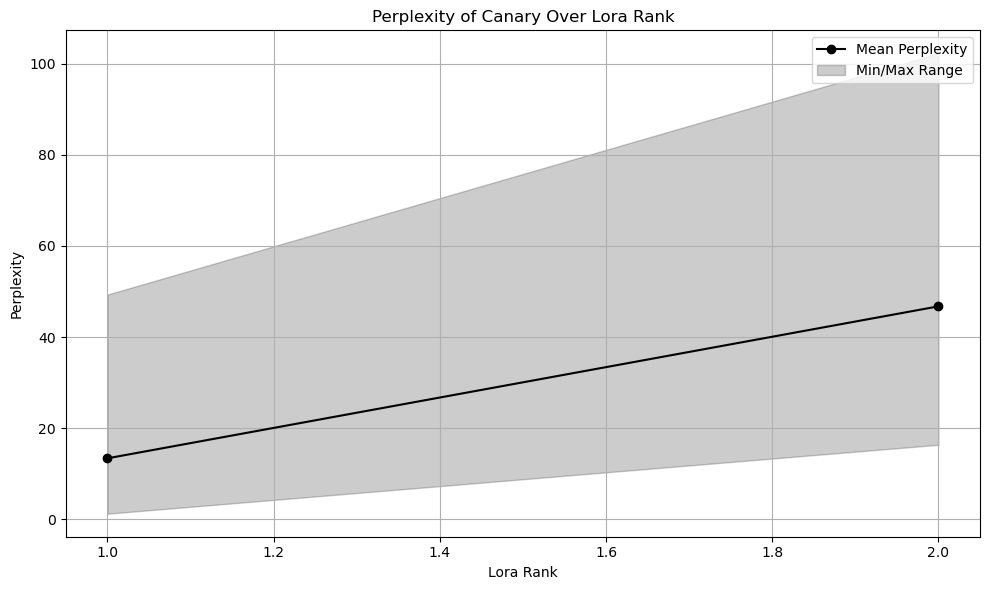

In [138]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a figure and axis

df = pd.DataFrame(results)


mean_perplexity = df.groupby('lora_rank')['perplexity'].mean().reset_index()
max_perplexity = df.groupby('lora_rank')['perplexity'].max().reset_index()
min_perplexity = df.groupby('lora_rank')['perplexity'].min().reset_index()


# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot mean perplexity
ax1.plot(mean_perplexity['lora_rank'], mean_perplexity['perplexity'], label='Mean Perplexity', color='black', marker='o')

# Shade the area between min and max perplexity
ax1.fill_between(mean_perplexity['lora_rank'], min_perplexity['perplexity'], max_perplexity['perplexity'], color='black', alpha=0.2, label='Min/Max Range')

# Set labels and title
ax1.set_xlabel('Lora Rank')
ax1.set_ylabel('Perplexity')
plt.title('Perplexity of Canary Over Lora Rank')

# Add a legend
ax1.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
# Define the output CSV file path
output_csv_path = '../experiments/experiment_results_new.csv'

# Write results to the CSV file
with open(output_csv_path, mode='w', newline='') as csvfile:
    fieldnames = ['canaries_number', 'lora_rank', 'perplexity', 'exposure']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for result in results:
        writer.writerow(result)

print(f"Results saved to {output_csv_path}")

ValueError: dict contains fields not in fieldnames: 'random_seed'

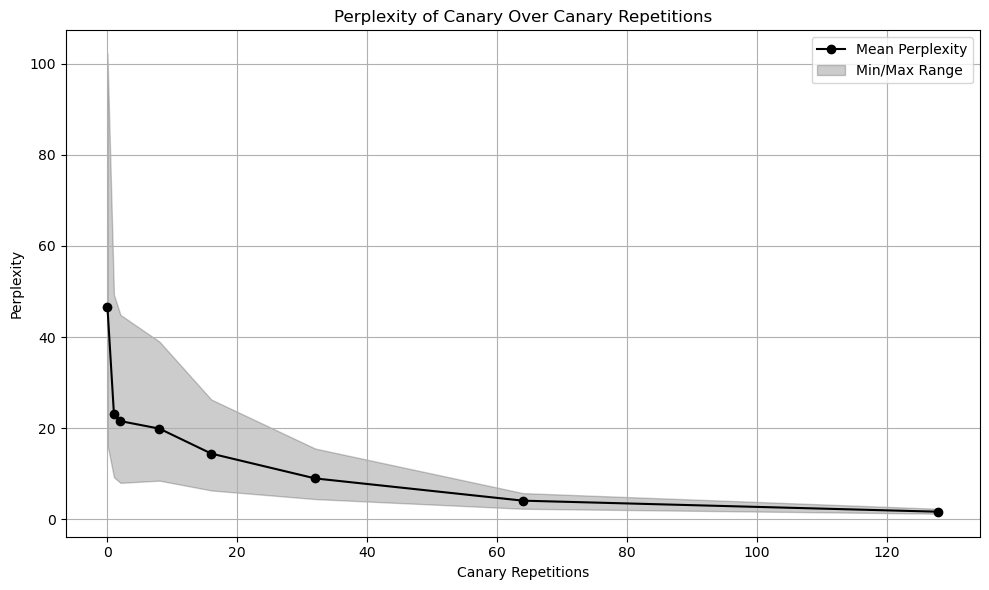

In [65]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a figure and axis

df = pd.DataFrame(results)


mean_perplexity = df.groupby('canaries_number')['perplexity'].mean().reset_index()
max_perplexity = df.groupby('canaries_number')['perplexity'].max().reset_index()
min_perplexity = df.groupby('canaries_number')['perplexity'].min().reset_index()


# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot mean perplexity
ax1.plot(mean_perplexity['canaries_number'], mean_perplexity['perplexity'], label='Mean Perplexity', color='black', marker='o')

# Shade the area between min and max perplexity
ax1.fill_between(mean_perplexity['canaries_number'], min_perplexity['perplexity'], max_perplexity['perplexity'], color='black', alpha=0.2, label='Min/Max Range')

# Set labels and title
ax1.set_xlabel('Canary Repetitions')
ax1.set_ylabel('Perplexity')
plt.title('Perplexity of Canary Over Canary Repetitions')

# Add a legend
ax1.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

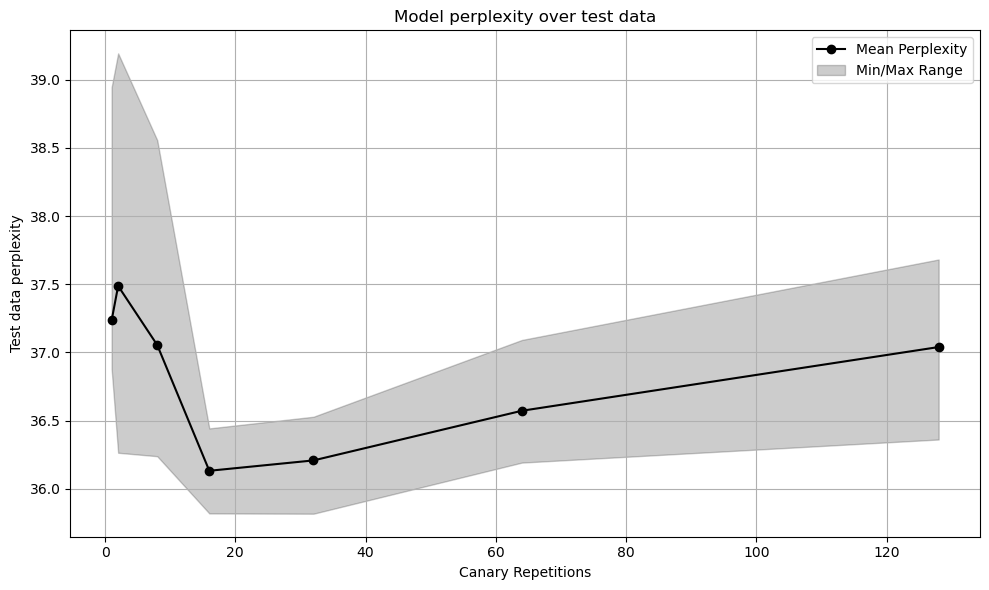

In [68]:


# Create a figure and axis

df = pd.DataFrame(results)


mean_perplexity = df.groupby('canaries_number')['test_perplexity'].mean().reset_index()
max_perplexity = df.groupby('canaries_number')['test_perplexity'].max().reset_index()
min_perplexity = df.groupby('canaries_number')['test_perplexity'].min().reset_index()


# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot mean perplexity
ax1.plot(mean_perplexity['canaries_number'], mean_perplexity['test_perplexity'], label='Mean Perplexity', color='black', marker='o')

# Shade the area between min and max perplexity
ax1.fill_between(mean_perplexity['canaries_number'], min_perplexity['test_perplexity'], max_perplexity['test_perplexity'], color='black', alpha=0.2, label='Min/Max Range')

# Set labels and title
ax1.set_xlabel('Canary Repetitions')
ax1.set_ylabel('Test data perplexity')
plt.title('Model perplexity over test data')

# Add a legend
ax1.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

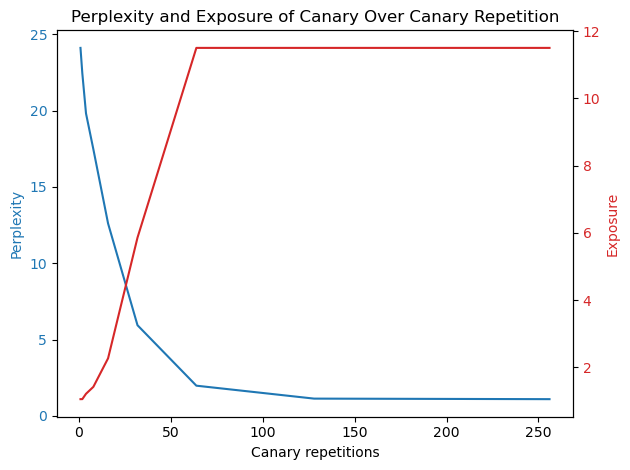

In [ ]:


# Data extracted from the given text


mean_perplexity = results.groupby('canaries_number')['perplexity'].mean().reset_index()
max_perplexity = results.groupby('canaries_number')['perplexity'].max().reset_index()
min_perplexity = results.groupby('canaries_number')['perplexity'].min().reset_index()



# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot perplexity on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Canary repetitions')
ax1.set_ylabel('Perplexity', color=color)
ax1.plot(canaries_number, perplexity, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# # Create a second y-axis for exposure
# ax2 = ax1.twinx()
# color = 'tab:red'
# ax2.set_ylabel('Exposure', color=color)
# ax2.plot(canaries_number, exposure, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# Add a title and show the plot
plt.title('Perplexity of Canary Over Canary Repetition')
fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
# Extract data for plotting
canaries_list = [result['canaries_number'] for result in results]
lora_rank_list = [result['lora_rank'] for result in results]
perplexities = [result['perplexity'] for result in results]
exposures = [result['exposure'] for result in results]

# Create scatter plots
plt.figure(figsize=(12, 6))

# Perplexity scatter plot
plt.subplot(1, 2, 1)
scatter = plt.scatter(canaries_list, lora_rank_list, c=perplexities, cmap='viridis')
plt.colorbar(scatter, label='Perplexity')
plt.xlabel('Canaries Number')
plt.ylabel('LoRA Rank')
plt.title('Perplexity vs Canaries Number and LoRA Rank')

# Exposure scatter plot
plt.subplot(1, 2, 2)
scatter = plt.scatter(canaries_list, lora_rank_list, c=exposures, cmap='plasma')
plt.colorbar(scatter, label='Exposure')
plt.xlabel('Canaries Number')
plt.ylabel('LoRA Rank')
plt.title('Exposure vs Canaries Number and LoRA Rank')

plt.tight_layout()
plt.show()

In [ ]:
def make_inference(context, qa_model, tokenizer):
  batch = tokenizer(context, return_tensors='pt').to("cuda:0")
  with torch.cuda.amp.autocast():
    output_tokens = qa_model.generate(**batch, max_new_tokens=40)

  display(Markdown((tokenizer.decode(output_tokens[0], skip_special_tokens=True))))

In [ ]:
def find_largest_common_ngram(tokens1, tokens2):
    len1 = tokens1.shape[1]
    len2 = tokens2.shape[1]

    max_n = min(len1, len2)

    for n in range(max_n, 0, -1):
        ngrams1 = set(tuple(tokens1[0, i:i+n].tolist()) for i in range(len1 - n + 1))
        ngrams2 = set(tuple(tokens2[0, i:i+n].tolist()) for i in range(len2 - n + 1))
        
        common_ngrams = ngrams1.intersection(ngrams2)
        
        if common_ngrams:
            return len(max(common_ngrams, key=len))  # Return the first found largest n-gram

    return None  # No common n-grams found

# Example tensors
tokens1 = torch.tensor([[2025, 6570, 2645, 12009, 6317, 284, 275, 330, 270, 11510]], device='cuda:0')
tokens2 = torch.tensor([[2645, 12009, 6317, 284, 275, 330, 270, 11510, 259, 267]], device='cuda:0')

# Find the largest common n-gram
largest_ngram = find_largest_common_ngram(tokens1, tokens2)
print("Largest Common n-gram:", largest_ngram)

In [106]:
output_tokens

tensor([[ 2025,  6570,  2645, 12009,  6317,   284,   275,   398,   420,  1968,
           500,    13,   198,   198]], device='cuda:0')

In [105]:
suffix['input_ids'][0]

tensor([  330,   270, 11510,   259,   267,   600,   434,    13],
       device='cuda:0')

In [116]:
model = AutoModelForCausalLM.from_pretrained('gpt2', return_dict=True, load_in_8bit=False, device_map='auto')


canaries_number = [1, 2, 8, 16, 32, 64, 128]

results_ngram = []

for k in random_seeds:
    random.seed(k)
    row = random.randint(0, len(ds['train']['context']) - 1)
    canary = ds['train']['context'][row]

    batch = tokenizer(canary, return_tensors='pt').to("cuda:0")
    
    # Calculate the midpoint
    midpoint = batch['input_ids'].shape[1] // 2

    # Split the tensors
    input_ids_1, input_ids_2 = torch.split(batch['input_ids'], [midpoint, batch['input_ids'].shape[1] - midpoint], dim=1)
    attention_mask_1, attention_mask_2 = torch.split(batch['attention_mask'], [midpoint, batch['attention_mask'].shape[1] - midpoint], dim=1)

    # Create two new batches
    prefix = {
        'input_ids': input_ids_1,
        'attention_mask': attention_mask_1
    }

    suffix = {
        'input_ids': input_ids_2,
        'attention_mask': attention_mask_2
    }

    # print(batch)
    # print(prefix)

    print(f"PREFIX ---- {tokenizer.decode(prefix['input_ids'][0])}")
    print(f"SUFFIX ---- {tokenizer.decode(suffix['input_ids'][0])}")


    for j in lora_rank:
        for i in canaries_number:
            model_name_trained = f"../models/gpt2/gpt2-finetuned-on-phee-{i}-canaries-{j}-rank-{k}-seed"
            print(f"Loading model {model_name_trained}")

            config = PeftConfig.from_pretrained(model_name_trained)
            # model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, return_dict=True, load_in_8bit=False, device_map='auto')
            qa_model = PeftModel.from_pretrained(model, model_name_trained)

            with torch.cuda.amp.autocast():
                output_tokens = qa_model.generate(**prefix, max_new_tokens=midpoint)            
            # display(Markdown((tokenizer.decode(output_tokens[0], skip_special_tokens=True))))
            print('\n GENERATED \n ----------')
            print(tokenizer.decode(output_tokens[0]))
            largest_ngram = find_largest_common_ngram(output_tokens, suffix['input_ids'])


            print(f"\n LARGEST N GRAM {largest_ngram}")
            print('\n----------')

            results_ngram.append({
                'canaries_number': i,
                'lora_rank': j,
                'random_seed' : k,
                'largest ngram': largest_ngram,
                'share of ngram': largest_ngram / midpoint if largest_ngram else 0
            })




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PREFIX ---- Anaphylactic reaction to b
SUFFIX ---- acitracin ointment.
Loading model ../models/gpt2/gpt2-finetuned-on-phee-1-canaries-1-rank-13-seed

 GENERATED 
 ----------
Anaphylactic reaction to bromocriptine.



 LARGEST N GRAM 1

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-2-canaries-1-rank-13-seed

 GENERATED 
 ----------
Anaphylactic reaction to bromocriptine.



 LARGEST N GRAM 1

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-8-canaries-1-rank-13-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
Anaphylactic reaction to bromocriptine.



 LARGEST N GRAM 1

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-16-canaries-1-rank-13-seed

 GENERATED 
 ----------
Anaphylactic reaction to baclofen.

The

 LARGEST N GRAM 1

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-32-canaries-1-rank-13-seed

 GENERATED 
 ----------
Anaphylactic reaction to bacitracin.



 LARGEST N GRAM 4

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-64-canaries-1-rank-13-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
Anaphylactic reaction to bacitracin.



 LARGEST N GRAM 4

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-128-canaries-1-rank-13-seed

 GENERATED 
 ----------
Anaphylactic reaction to bacitracin ointment

 LARGEST N GRAM 7

----------
PREFIX ---- Although moderate myelosuppression is not uncommonly seen in patients treated with lenalidom
SUFFIX ---- ide, aplastic anemia has not previously been reported to be associated with this agent.
Loading model ../models/gpt2/gpt2-finetuned-on-phee-1-canaries-1-rank-7-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
Although moderate myelosuppression is not uncommonly seen in patients treated with lenalidomide, the use of this drug may be a potential risk factor for the development of severe my

 LARGEST N GRAM 2

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-2-canaries-1-rank-7-seed

 GENERATED 
 ----------
Although moderate myelosuppression is not uncommonly seen in patients treated with lenalidomide, it is important to note that the patient's history of severe myelogenous leukemia is

 LARGEST N GRAM 2

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-8-canaries-1-rank-7-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
Although moderate myelosuppression is not uncommonly seen in patients treated with lenalidomide, the use of this drug may be a potential risk factor for the development of myel

 LARGEST N GRAM 2

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-16-canaries-1-rank-7-seed

 GENERATED 
 ----------
Although moderate myelosuppression is not uncommonly seen in patients treated with lenalidomide, the use of lenalidomide may be a potential complication.

The use

 LARGEST N GRAM 2

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-32-canaries-1-rank-7-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
Although moderate myelosuppression is not uncommonly seen in patients treated with lenalidomide, the use of lenalidomide may be associated with a higher incidence of myel

 LARGEST N GRAM 3

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-64-canaries-1-rank-7-seed

 GENERATED 
 ----------
Although moderate myelosuppression is not uncommonly seen in patients treated with lenalidomide, the use of lenalidomide in this patient was not reported. The patient was

 LARGEST N GRAM 2

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-128-canaries-1-rank-7-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
Although moderate myelosuppression is not uncommonly seen in patients treated with lenalidomide, aplastic anemia has not previously been reported to be associated with this agent.

 LARGEST N GRAM 19

----------
PREFIX ---- OBJECTIVE: To report 2 cases of serotonin syndrome with serious extrapyramidal movement disorders occurring when
SUFFIX ----  metoclopramide was coadministered with sertraline or venlafaxine.
Loading model ../models/gpt2/gpt2-finetuned-on-phee-1-canaries-1-rank-81-seed

 GENERATED 
 ----------
OBJECTIVE: To report 2 cases of serotonin syndrome with serious extrapyramidal movement disorders occurring when the patient was treated with a serotonin reuptake inhibitor.

METHODS: The patient was treated


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 LARGEST N GRAM 1

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-2-canaries-1-rank-81-seed

 GENERATED 
 ----------
OBJECTIVE: To report 2 cases of serotonin syndrome with serious extrapyramidal movement disorders occurring when the patient was treated with serotonin reuptake inhibitors.

To describe the first case of serotonin syndrome


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 LARGEST N GRAM 1

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-8-canaries-1-rank-81-seed

 GENERATED 
 ----------
OBJECTIVE: To report 2 cases of serotonin syndrome with serious extrapyramidal movement disorders occurring when the patient was treated with a serotonin reuptake inhibitor.

OBJECTIVE: To describe the

 LARGEST N GRAM 1

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-16-canaries-1-rank-81-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
OBJECTIVE: To report 2 cases of serotonin syndrome with serious extrapyramidal movement disorders occurring when the use of serotonin reuptake inhibitors (SSRIs) was discontinued.

METHOD: We

 LARGEST N GRAM 1

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-32-canaries-1-rank-81-seed

 GENERATED 
 ----------
OBJECTIVE: To report 2 cases of serotonin syndrome with serious extrapyramidal movement disorders occurring when intravenous serotonin was administered intravenously. The first case was a patient with a history of acute myel


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 LARGEST N GRAM 1

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-64-canaries-1-rank-81-seed

 GENERATED 
 ----------
OBJECTIVE: To report 2 cases of serotonin syndrome with serious extrapyramidal movement disorders occurring when metoclopramide was coadministered with venlafaxine. The first case was a

 LARGEST N GRAM 10

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-128-canaries-1-rank-81-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
OBJECTIVE: To report 2 cases of serotonin syndrome with serious extrapyramidal movement disorders occurring when metoclopramide was coadministered with venlafaxine or venlafaxine

 LARGEST N GRAM 10

----------
PREFIX ---- Perinatal vasoconstrictive renal ins
SUFFIX ---- ufficiency associated with maternal nimesulide use.
Loading model ../models/gpt2/gpt2-finetuned-on-phee-1-canaries-1-rank-17-seed

 GENERATED 
 ----------
Perinatal vasoconstrictive renal insufficiency. Lancet. 5:843-

 LARGEST N GRAM 2

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-2-canaries-1-rank-17-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
Perinatal vasoconstrictive renal insufficiency in a patient with a history of renal

 LARGEST N GRAM 2

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-8-canaries-1-rank-17-seed

 GENERATED 
 ----------
Perinatal vasoconstrictive renal insufficiency associated with the use of thiazide

 LARGEST N GRAM 4

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-16-canaries-1-rank-17-seed

 GENERATED 
 ----------
Perinatal vasoconstrictive renal insufficiency associated with the administration of thiazide

 LARGEST N GRAM 4

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-32-canaries-1-rank-17-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
Perinatal vasoconstrictive renal insufficiency associated with the use of thiazide

 LARGEST N GRAM 4

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-64-canaries-1-rank-17-seed

 GENERATED 
 ----------
Perinatal vasoconstrictive renal insufficiency associated with maternal maternal maternal maternal use of

 LARGEST N GRAM 5

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-128-canaries-1-rank-17-seed

 GENERATED 
 ----------
Perinatal vasoconstrictive renal insufficiency associated with maternal nimesulide use

 LARGEST N GRAM 10

----------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PREFIX ---- A more serious development of adrenal insufficiency
SUFFIX ----  may occur upon the improper replacement of systemic steroids.
Loading model ../models/gpt2/gpt2-finetuned-on-phee-1-canaries-1-rank-75-seed

 GENERATED 
 ----------
A more serious development of adrenal insufficiency following the administration of thiazide therapy is the

 LARGEST N GRAM 1

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-2-canaries-1-rank-75-seed

 GENERATED 
 ----------
A more serious development of adrenal insufficiency following treatment with a selective serotonin reuptake inhibitor

 LARGEST N GRAM 1

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-8-canaries-1-rank-75-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
A more serious development of adrenal insufficiency following the administration of thiazolidinediones

 LARGEST N GRAM 1

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-16-canaries-1-rank-75-seed

 GENERATED 
 ----------
A more serious development of adrenal insufficiency following the administration of phenytoin is reported

 LARGEST N GRAM 1

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-32-canaries-1-rank-75-seed

 GENERATED 
 ----------
A more serious development of adrenal insufficiency may occur in the development of a syndrome of adren


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 LARGEST N GRAM 2

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-64-canaries-1-rank-75-seed

 GENERATED 
 ----------
A more serious development of adrenal insufficiency may occur during the administration of a selective serotonin re

 LARGEST N GRAM 2

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-128-canaries-1-rank-75-seed

 GENERATED 
 ----------
A more serious development of adrenal insufficiency may occur upon the improper replacement of systemic steroids.

 LARGEST N GRAM 10

----------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PREFIX ---- After receiving 3 doses of ifosfamide/
SUFFIX ---- mesna, she was found to be unresponsive.
Loading model ../models/gpt2/gpt2-finetuned-on-phee-1-canaries-1-rank-90-seed

 GENERATED 
 ----------
After receiving 3 doses of ifosfamide/tetrahydrocannabinol (THC

 LARGEST N GRAM None

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-2-canaries-1-rank-90-seed

 GENERATED 
 ----------
After receiving 3 doses of ifosfamide/tetrahydrocannabinol (TCM


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 LARGEST N GRAM None

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-8-canaries-1-rank-90-seed

 GENERATED 
 ----------
After receiving 3 doses of ifosfamide/diazolidinedioni, the patient developed

 LARGEST N GRAM 1

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-16-canaries-1-rank-90-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
After receiving 3 doses of ifosfamide/diphenhydramine, she developed a

 LARGEST N GRAM 2

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-32-canaries-1-rank-90-seed

 GENERATED 
 ----------
After receiving 3 doses of ifosfamide/diclofenac, she developed a

 LARGEST N GRAM 2

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-64-canaries-1-rank-90-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
After receiving 3 doses of ifosfamide/mesosfamide, she was found to be

 LARGEST N GRAM 6

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-128-canaries-1-rank-90-seed

 GENERATED 
 ----------
After receiving 3 doses of ifosfamide/mesna, she was found to be unresponsive

 LARGEST N GRAM 10

----------
PREFIX ---- The authors think that although lamivudine is widely used and well
SUFFIX ----  tolerated, it can cause ADRs, which are reversible after drug withdrawal.
Loading model ../models/gpt2/gpt2-finetuned-on-phee-1-canaries-1-rank-0-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
The authors think that although lamivudine is widely used and well tolerated, it is not a potent inhibitor of the immune system. They

 LARGEST N GRAM 3

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-2-canaries-1-rank-0-seed

 GENERATED 
 ----------
The authors think that although lamivudine is widely used and well tolerated, it is not a common drug in the United States. The

 LARGEST N GRAM 3

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-8-canaries-1-rank-0-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
The authors think that although lamivudine is widely used and well tolerated, it is not recommended for use in patients with severe depression.

 LARGEST N GRAM 3

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-16-canaries-1-rank-0-seed

 GENERATED 
 ----------
The authors think that although lamivudine is widely used and well tolerated, it is not recommended for use in patients with severe depression.

 LARGEST N GRAM 3

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-32-canaries-1-rank-0-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
The authors think that although lamivudine is widely used and well tolerated, it is not recommended for use in patients with chronic hepatitis C

 LARGEST N GRAM 3

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-64-canaries-1-rank-0-seed

 GENERATED 
 ----------
The authors think that although lamivudine is widely used and well tolerated, it is not well tolerated. Therefore, the use of lam

 LARGEST N GRAM 3

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-128-canaries-1-rank-0-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
The authors think that although lamivudine is widely used and well tolerated, it can cause ADRs, which are reversible after drug withdrawal

 LARGEST N GRAM 14

----------
PREFIX ---- We describe a patient with metastatic prostate cancer who developed non
SUFFIX ---- oliguric renal failure during treatment with suramin.
Loading model ../models/gpt2/gpt2-finetuned-on-phee-1-canaries-1-rank-10-seed

 GENERATED 
 ----------
We describe a patient with metastatic prostate cancer who developed non-specific acute renal failure after treatment with methotrexate

 LARGEST N GRAM 2

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-2-canaries-1-rank-10-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
We describe a patient with metastatic prostate cancer who developed non-specific acute renal failure after treatment with methotrexate

 LARGEST N GRAM 2

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-8-canaries-1-rank-10-seed

 GENERATED 
 ----------
We describe a patient with metastatic prostate cancer who developed non-specific lymphocytic lymphocytic leukemia after treatment with

 LARGEST N GRAM 2

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-16-canaries-1-rank-10-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
We describe a patient with metastatic prostate cancer who developed non-small cell lung cancer after treatment with a selective serotonin re

 LARGEST N GRAM 2

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-32-canaries-1-rank-10-seed

 GENERATED 
 ----------
We describe a patient with metastatic prostate cancer who developed non-small cell lung cancer after treatment with amiodarone

 LARGEST N GRAM 2

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-64-canaries-1-rank-10-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
We describe a patient with metastatic prostate cancer who developed non-small cell lung cancer after treatment with diclof

 LARGEST N GRAM 2

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-128-canaries-1-rank-10-seed

 GENERATED 
 ----------
We describe a patient with metastatic prostate cancer who developed non-small cell lung cancer during treatment with suramin. The

 LARGEST N GRAM 6

----------
PREFIX ---- We report a patient who developed spontaneous splenic infarction after
SUFFIX ----  the use of sumatriptan for the treatment of migraine headache.
Loading model ../models/gpt2/gpt2-finetuned-on-phee-1-canaries-1-rank-36-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
We report a patient who developed spontaneous splenic infarction after treatment with thalidomide. The patient was treated with th

 LARGEST N GRAM 1

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-2-canaries-1-rank-36-seed

 GENERATED 
 ----------
We report a patient who developed spontaneous splenic infarction after treatment with thalidomide. The patient was treated with th

 LARGEST N GRAM 1

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-8-canaries-1-rank-36-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
We report a patient who developed spontaneous splenic infarction after the use of the selective serotonin reuptake inhibitor (SSRI

 LARGEST N GRAM 3

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-16-canaries-1-rank-36-seed

 GENERATED 
 ----------
We report a patient who developed spontaneous splenic infarction after treatment with the selective serotonin reuptake inhibitor ritalin.

 LARGEST N GRAM 1

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-32-canaries-1-rank-36-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
We report a patient who developed spontaneous splenic infarction after the administration of the selective serotonin reuptake inhibitor (SSRI

 LARGEST N GRAM 1

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-64-canaries-1-rank-36-seed

 GENERATED 
 ----------
We report a patient who developed spontaneous splenic infarction after the use of the selective serotonin reuptake inhibitor (SSRI

 LARGEST N GRAM 3

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-128-canaries-1-rank-36-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
We report a patient who developed spontaneous splenic infarction after the use of sumatriptan for the treatment of migraine headache

 LARGEST N GRAM 13

----------
PREFIX ---- Though physicians treating large populations of patients with HIV are well aware of this complication, only one other
SUFFIX ----  report of nevirapine-associated SJS has been documented in the dermatology literature.
Loading model ../models/gpt2/gpt2-finetuned-on-phee-1-canaries-1-rank-99-seed

 GENERATED 
 ----------
Though physicians treating large populations of patients with HIV are well aware of this complication, only one other case of this complication has been reported. This case was reported in a patient with a history of

 LARGEST N GRAM 2

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-2-canaries-1-rank-99-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
Though physicians treating large populations of patients with HIV are well aware of this complication, only one other case has been reported. This case involved a patient with a history of hepatitis B who developed a

 LARGEST N GRAM 2

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-8-canaries-1-rank-99-seed

 GENERATED 
 ----------
Though physicians treating large populations of patients with HIV are well aware of this complication, only one other case of a patient with HIV-infected patients has been reported. This case was reported in

 LARGEST N GRAM 2

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-16-canaries-1-rank-99-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
Though physicians treating large populations of patients with HIV are well aware of this complication, only one other case of a patient with HIV-infected patients with a history of hepatitis B virus infection has

 LARGEST N GRAM 1

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-32-canaries-1-rank-99-seed

 GENERATED 
 ----------
Though physicians treating large populations of patients with HIV are well aware of this complication, only one other report has been reported on the association between the use of methotrexate and HIV infection.

 LARGEST N GRAM 2

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-64-canaries-1-rank-99-seed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 GENERATED 
 ----------
Though physicians treating large populations of patients with HIV are well aware of this complication, only one other report of a case of acute hepatitis B infection has been reported. This report describes a case of

 LARGEST N GRAM 2

----------
Loading model ../models/gpt2/gpt2-finetuned-on-phee-128-canaries-1-rank-99-seed

 GENERATED 
 ----------
Though physicians treating large populations of patients with HIV are well aware of this complication, only one other report of nevirapine-associated SJS has been documented in the dermatology literature.

 LARGEST N GRAM 19

----------


In [131]:
max = __builtins__.max
min = __builtins__.max


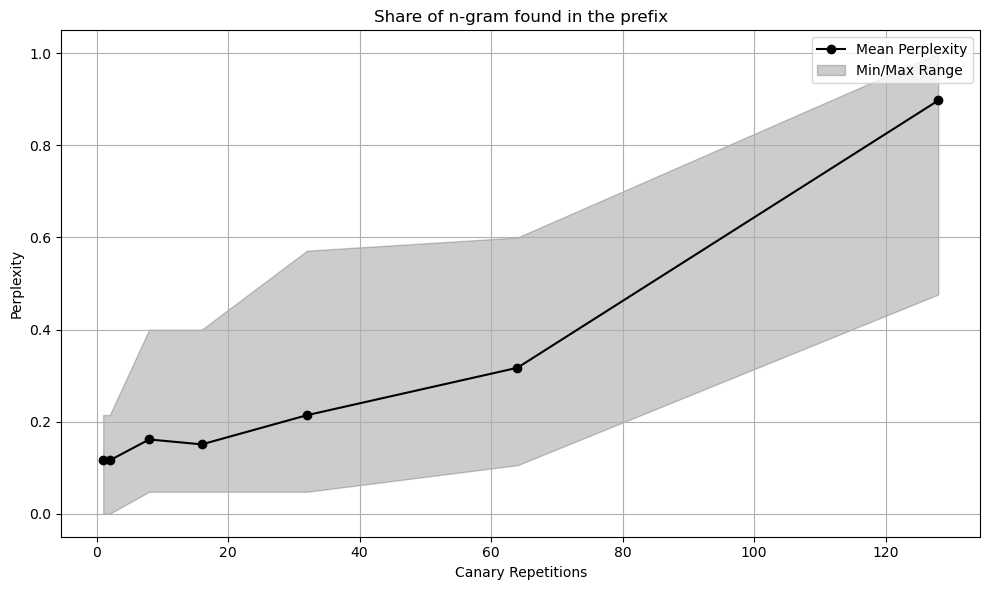

In [119]:
df = pd.DataFrame(results_ngram)


mean_df = df.groupby('canaries_number')['share of ngram'].mean().reset_index()
max_df = df.groupby('canaries_number')['share of ngram'].max().reset_index()
min_df = df.groupby('canaries_number')['share of ngram'].min().reset_index()


# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot mean perplexity
ax1.plot(mean['canaries_number'], mean['share of ngram'], label='Mean Perplexity', color='black', marker='o')

# Shade the area between min and max perplexity
ax1.fill_between(mean['canaries_number'], min['share of ngram'], max['share of ngram'], color='black', alpha=0.2, label='Min/Max Range')

# Set labels and title
ax1.set_xlabel('Canary Repetitions')
ax1.set_ylabel('Perplexity')
plt.title('Share of n-gram found in the prefix')

# Add a legend
ax1.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [115]:
results_ngram

[{'canaries_number': 1,
  'lora_rank': 1,
  'random_seed': 13,
  'largest ngram': 1,
  'share of ngram': 0.14285714285714285},
 {'canaries_number': 2,
  'lora_rank': 1,
  'random_seed': 13,
  'largest ngram': 1,
  'share of ngram': 0.14285714285714285},
 {'canaries_number': 8,
  'lora_rank': 1,
  'random_seed': 13,
  'largest ngram': 1,
  'share of ngram': 0.14285714285714285},
 {'canaries_number': 16,
  'lora_rank': 1,
  'random_seed': 13,
  'largest ngram': 1,
  'share of ngram': 0.14285714285714285},
 {'canaries_number': 32,
  'lora_rank': 1,
  'random_seed': 13,
  'largest ngram': 4,
  'share of ngram': 0.5714285714285714},
 {'canaries_number': 64,
  'lora_rank': 1,
  'random_seed': 13,
  'largest ngram': 4,
  'share of ngram': 0.5714285714285714},
 {'canaries_number': 128,
  'lora_rank': 1,
  'random_seed': 13,
  'largest ngram': 7,
  'share of ngram': 1.0},
 {'canaries_number': 1,
  'lora_rank': 1,
  'random_seed': 7,
  'largest ngram': 2,
  'share of ngram': 0.10526315789473684}

Largest Common n-gram: 8
